### Description

Here should be exploratorial analysis - different plots, attempts to understand data, etc.

In [40]:
import os
os.getcwd()

'/work/train-of-thought/notebooks'

In [41]:
!pip install pycairo


You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.


In [42]:
import os
import sys
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import igraph

In [46]:
os.listdir("../data")

['sources.csv.gz',
 'input_wagon.xlsx',
 'orders7.csv.gz',
 'orders8.csv.gz',
 'wagon_mode_compat.csv.gz',
 'description.txt',
 'output_wagon.xlsx',
 'metrics.csv.gz',
 'standplaces.csv.gz']

In [44]:
df = pd.read_excel("../data/input_wagon.xlsx", sheet_name=None)

In [45]:
list(df)

['Orders_07',
 'Orders_08',
 'WagonModelCompatibility',
 'sources',
 'standplaces',
 'Metrics']

# EDA таблиц

## 1. Orders_07

Что сделать/выяснить:
- [ ] посмотреть ID заказа - есть ли закономерности. Часть номеров короткие - с чем это может быть связано?
- [ ] тариф: как интерпретировать набор цифр с разделителями?

In [48]:
def read_table(table_name="Orders_07"):
    table_df = df[table_name]
    columns = table_df.columns
    column_names = table_df.iloc[0].values
    table_df = table_df.loc[1:]
    table_df.columns = column_names
    for c, d in zip(columns, column_names):
        print(d, "-", c)
    return table_df

orders7 = read_table("Orders_07")

OrderNum - ID заказа
Start - Вершина старта
Finish - Вершина финиша
StartDate - Дата старта относительно дня запуска расчета, сутки
Dur - Время выполнения заказа (движения по арке+погрузка и разгрузка, сутки)
MinUnit - Минимальный обьем заказа, вагоны
MaxUnit - Максимальный обьем заказа, вагоны
Tariff - Тариф в зависимотси от отклонения от даты старта ( за вагон), рубли
NeedWagonModel - Запрошенная категория вагона
ShortagePenalty - Категория приоритетности заказа (убывание от 1 до 4)


In [50]:
orders7.to_csv("../data/orders7.csv.gz", index=None)

In [51]:
orders7.head()

,OrderNum,Start,Finish,StartDate,Dur,MinUnit,MaxUnit,Tariff,NeedWagonModel,ShortagePenalty
1,302201_812941937003_0707,932103,937003,0,13,3,3,53514:52334:51154:49974,2039,4
2,303139_830582944702_0707,946801,944702,0,13,2,3,8550:7370:6190:5010,2025,4
3,303933_830578944702_0707,946801,944702,0,13,2,3,8550:7370:6190:5010,2025,4
4,305170_830580944702_0707,946801,944702,0,13,2,3,8550:7370:6190:5010,2025,4
5,303071_814704942105_0707,946801,942105,0,14,2,2,25768:24588:23408:22228,2011,4


In [52]:
start_nodes = orders7.Start
end_nodes = orders7.Finish
nodes = np.concatenate([
    np.unique(start_nodes),
    np.unique(end_nodes)
])
nodes = np.unique(nodes)
nodes.shape

(709,)

## Orders_8

In [53]:
orders8 = read_table("Orders_08")

OrderNum - ID заказа
Start - Вершина старта
Finish - Вершина финиша
StartDate - Дата старта относительно дня запуска расчета, сутки
Dur - Время выполнения заказа (движения по арке+погрузка и разгрузка, сутки)
MinUnit - Минимальный обьем заказа, вагоны
MaxUnit - Максимальный обьем заказа, вагоны
Tariff - Тариф в зависимотси от отклонения от даты старта ( за вагон), рубли
NeedWagonModel - Запрошенная категория вагона
ShortagePenalty - Категория приоритетности заказа (убывание от 1 до 4)


In [54]:
orders8.to_csv("../data/orders8.csv.gz", index=None)

In [55]:
start_nodes = orders8.Start
end_nodes = orders8.Finish
nodes = np.concatenate([
    np.unique(start_nodes),
    np.unique(end_nodes)
])
nodes = np.unique(nodes)
nodes.shape

(648,)

## WagonModelCompatibility

Вопросы:
- [ ] совместимы ли разные типы вагонов в одну сторону, или связь двусторонняя? То есть если A -> B (A - запрошенный тип, B - совместимый тип), C->B, можно ли сказать, что A->C, а C -> A?

In [56]:
wagon_mode_compat = read_table("WagonModelCompatibility")

NeedWagonModel - Запрошенный тип вагона
CompatibleWagonModel - Совместимый тип вагона


In [57]:
wagon_mode_compat.to_csv("../data/wagon_mode_compat.csv.gz", index=None)

In [58]:
w1 = np.unique(wagon_mode_compat.iloc[:, 0])
w2 = np.unique(wagon_mode_compat.iloc[:, 1])
w3 = np.unique(np.concatenate([w1, w2]))
w1.shape, w2.shape, w3.shape

((492,), (63,), (493,))

In [59]:
wagon_mode_compat.groupby("NeedWagonModel").count().head()

,CompatibleWagonModel
NeedWagonModel,
2001,63
2002,29
2003,53
2004,53
2005,24


нарисуем граф с моделями вагонов. Есть ли отдельные компоненты связности?

In [18]:
from igraph import *
name2vertex = dict()
graph = Graph()
for s, e in wagon_mode_compat.values:
    s = str(s)
    e = str(e)
    if s not in name2vertex:
        u = graph.add_vertex(s)
        name2vertex[s] = u
    else:
        u = name2vertex[s]
    if e not in name2vertex:
        v = graph.add_vertex(name=e)
        name2vertex[e] = v
    else:
        v = name2vertex[e]
    selection = graph.es.select(_from=s, _to=e)
    if len(selection) < 1:
        k = graph.add_edge(u, v)


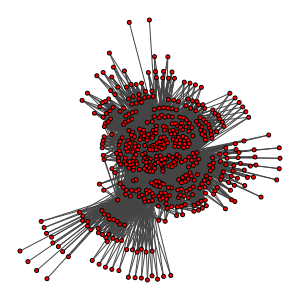

In [19]:
layout = graph.layout("fr")
plot(graph, layout=layout, bbox = (300, 300), margin=20, vertex_size=4, edge_width=1)

In [20]:
clusters = list(graph.community_fastgreedy().as_clustering())

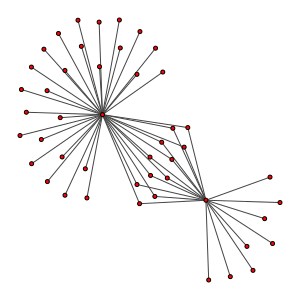

In [21]:
c = clusters[0]
sgr = graph.subgraph(c)
layout = sgr.layout("fr")
plot(sgr, layout=layout, bbox = (300, 300), margin=20, vertex_size=4, edge_width=1)

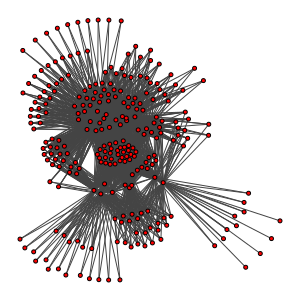

In [22]:
c = clusters[1]
sgr = graph.subgraph(c)
layout = sgr.layout("fr")
plot(sgr, layout=layout, bbox = (300, 300), margin=20, vertex_size=4, edge_width=1)

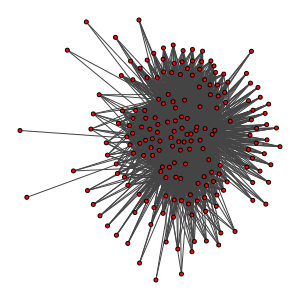

In [23]:
c = clusters[2]
sgr = graph.subgraph(c)
layout = sgr.layout("fr")
plot(sgr, layout=layout, bbox = (300, 300), margin=20, vertex_size=4, edge_width=1)

## sources

In [60]:
sources = read_table("sources")

Station - Станция дислокации (стоянки или освобождения после заказа)
Date - День, начиная с которого вагоны доступны (отсчет с дня запуска расчета)
Units - Количество вагонов, в  день дислокации
Stand - Формула расчета простоя (руб за сутки простоя на станции дислокации 1 вагона)
WagonModel - Модель вагонов


In [61]:
sources.to_csv("../data/sources.csv.gz", index=None)

## standplaces

In [62]:
standplaces = read_table("standplaces")

Station - Код станции отстоя
PricePut - Стоимость отстоя, руб за факт входа без расчета суток
PriceStand - Цена простоя в сутки


In [63]:
standplaces.to_csv("../data/standplaces.csv.gz", index=None)

## Metrics

In [64]:
metrics = read_table("Metrics")

From - Узел старта
To - Узел финиша
Group - Группа пробега
Distance - Расстояние пробега, км
Time - Время пробега, сутки
PriceUnit - Стоимость пробега, руб


In [65]:
metrics.to_csv("../data/metrics.csv.gz", index=None)

In [66]:
metrics.head()

,From,To,Group,Distance,Time,PriceUnit
1,10002,10303,100,9,5,104
2,10002,10303,200,9,5,138
3,10002,10303,305,9,5,355
4,10002,10905,100,60,5,685
5,10002,10905,200,60,5,914


# Targets
what is expected as a result

In [31]:
df2 = pd.read_excel("../data/output_wagon.xlsx", sheet_name=None)

In [32]:
list(df2)

['KPI', 'Orders', 'emptyMoves']

In [33]:
df2["KPI"]  # надо понять, какие из них желтые без ms excel

,"Расчет за 7 месяц (включая заявки которые ""выехали"" в 7 месяце)",Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5
0,приоритет,1.0,2.0,3.0,4.0,всего
1,всего заказов,NaN,NaN,NaN,NaN,NaN
2,Выполненных заказов в кол-ве,NaN,NaN,NaN,NaN,NaN
3,Выполненных заказов в вагонах,NaN,NaN,NaN,NaN,NaN
4,% выполнения,NaN,NaN,NaN,NaN,NaN
5,Средняя премия,NaN,NaN,NaN,NaN,NaN
6,Суммарная премия,NaN,NaN,NaN,NaN,NaN
7,Кол-во порожних пробегов,NaN,NaN,NaN,NaN,NaN
8,Суммарная стоимость порожних пробегов,NaN,NaN,NaN,NaN,NaN
9,Кол-во вагново отправленных на станции отстоя,NaN,NaN,NaN,NaN,NaN


In [34]:
df2["Orders"]

,Код заказа,Станция старта,Станция финиша,Расчетная дата старта,Плановая дата старта,Время в пути,Мин допустимый объем,Запрошенный объем,Тарифы,Запрошенный тип вагона,Приоритет,Примененный тариф
0,OrderNum,Start,Finish,StartDate,StartDatePlan,Dur,MinUnit,MaxUnit,Tariffs,NeedWagonModel,ShortagePenalty,Tariff used
1,310225_836697942105_0804,946801,942105,0,NaN,14,1,1,10395:9215:8035:6855,2025,4,NaN


In [35]:
df2["emptyMoves"]

,Отправление,Прибытие,Тип простоя,Модель вагона,День отправления (от начала расчета),День прибытия (от начала расчета),Количество,Цена порожнего пробега (за вагон),Код следующего заказа,Расчитанный тариф следующего заказа
0,801301,801208,P,2052,20,25,1,383,304382_817369883809_0731(1),NaN


In [37]:

class Order(object):
    def __init__(self, start_point, end_point, wagons, wagon_type, cost_per_day, days):
        self.start_point = start_point
        self.end_point = end_point
        self.wagons = wagons
        self.wagon_type = wagon_type
        self.cost_per_wagon = cost_per_wagon
        self.days = days

    def total_profit(self):
        return self.wagons * self.cost_per_wagon



class Wagon(object):
    def __init__(self, type_of_wagon, current_station, occupied, free_day, free_station):
        self.type_of_wagon = type_of_wagon
        self.occupied = occupied
        self.current_station = current_station
        self.free_day = free_day
        self.free_station = free_station
        
    def get_day_cost(self, stay_stations):
        if self.occupied:
            return 0
        else:
            return stay_stations[self.current_station]




    
class WagonManager(object):
    def __init__(self, wagons):
        pass



In [38]:
%load_ext autoreload
%autoreload 2

In [39]:
if not ".." in sys.path:
    sys.path.insert(0, "..")

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=7ba67d69-ce72-437b-8bf4-6d3c9b906c4a' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>